<a href="https://www.kaggle.com/code/lotfiezzeddini/fish-detection-faster-cnn?scriptVersionId=154399269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


In [4]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.3 MB/s eta 0:00:00


In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [6]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform


In [7]:
class FishDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)

        # Filtrer les boîtes englobantes invalides (largeur ou hauteur nulle)
        target = [t for t in target if t['bbox'][2] > 0 and t['bbox'][3] > 0]

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

            image = transformed['image']
            boxes = transformed['bboxes']

            new_boxes = []  # convert from xywh to xyxy
            for box in boxes:
                xmin, ymin, width, height = box[:4]
                xmax = xmin + max(0.1, width)  # ajuster x_max si x_min est égal à x_max
                ymax = ymin + max(0.1, height)  # ajuster y_max si y_min est égal à y_max

                # Vérification de la validité des coordonnées de la boîte englobante
                if xmax > xmin and ymax > ymin:
                    new_boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.tensor(new_boxes, dtype=torch.float32)

            targ = {}  # here is our transformed target
            targ['boxes'] = boxes
            targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
            targ['image_id'] = torch.tensor([t['image_id'] for t in target])
            targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # we have a different area
            targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
            return image.div(255), targ  # scale images

    def __len__(self):
        return len(self.ids)

In [8]:
dataset_path = "/kaggle/input/fish-detection-faster-r-cnn/fish detection"

In [9]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [11]:
train_dataset = FishDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


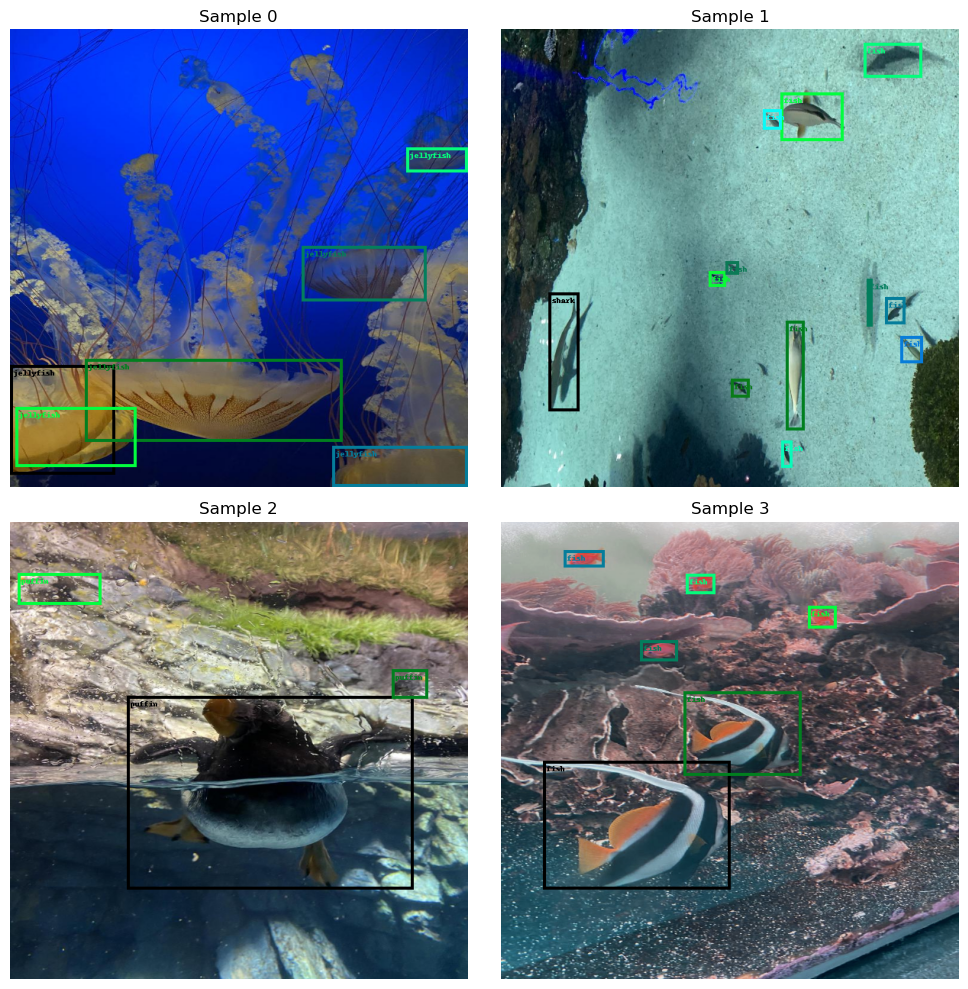

In [12]:
# Créer une figure avec une grille 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Obtenir les 4 échantillons
samples = [train_dataset[i] for i in range(4)]

# Parcourir les échantillons et les afficher dans la grille
for i in range(2):
    for j in range(2):
        sample = samples[i*2 + j]
        img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
        img_with_boxes = draw_bounding_boxes(
            img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
        ).permute(1, 2, 0)

        # Afficher l'image dans la sous-figure correspondante
        axs[i, j].imshow(img_with_boxes)
        axs[i, j].set_title(f'Sample {i*2 + j}')  # Titre de l'image
        axs[i, j].axis('off')  # Désactiver les axes

# Afficher la figure
plt.tight_layout()
plt.show()

In [13]:
len(train_dataset)

447

In [14]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 215MB/s]


In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [17]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [18]:
device = torch.device("cuda") # use GPU to train

In [19]:
model = model.to(device)

In [20]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [21]:
import sys

In [22]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Convertir les cibles en tensors et les envoyer au GPU
        
        optimizer.zero_grad()
        
        # Faire une prédiction
        loss_dict = model(images, targets)  # Le modèle calcule la perte automatiquement si nous passons les cibles
        
        # Calculer la perte totale
        losses = sum(loss for loss in loss_dict.values())
        
        # Rétropropagation et mise à jour des poids
        losses.backward()
        optimizer.step()
        
        # Enregistrer les pertes
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        all_losses_dict.append(loss_dict_append)
        all_losses.append(losses.item())
        
        if not math.isfinite(losses.item()):
            print(f"Loss is {losses.item()}, stopping training")
            print(loss_dict)
            sys.exit(1)
    
    # Afficher les statistiques d'entraînement
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [23]:
num_epochs=50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 112/112 [00:22<00:00,  4.88it/s]


Epoch 0, lr: 0.010000, loss: 0.993194, loss_classifier: 0.472705, loss_box: 0.388389, loss_rpn_box: 0.032600, loss_object: 0.099499


100%|██████████| 112/112 [00:16<00:00,  6.69it/s]


Epoch 1, lr: 0.010000, loss: 0.788658, loss_classifier: 0.354473, loss_box: 0.345017, loss_rpn_box: 0.028400, loss_object: 0.060768


100%|██████████| 112/112 [00:16<00:00,  6.74it/s]


Epoch 2, lr: 0.010000, loss: 0.704091, loss_classifier: 0.293839, loss_box: 0.335371, loss_rpn_box: 0.026168, loss_object: 0.048713


100%|██████████| 112/112 [00:16<00:00,  6.86it/s]


Epoch 3, lr: 0.010000, loss: 0.692082, loss_classifier: 0.277402, loss_box: 0.345422, loss_rpn_box: 0.025128, loss_object: 0.044131


100%|██████████| 112/112 [00:16<00:00,  6.91it/s]


Epoch 4, lr: 0.010000, loss: 0.662681, loss_classifier: 0.256409, loss_box: 0.345842, loss_rpn_box: 0.024348, loss_object: 0.036082


100%|██████████| 112/112 [00:15<00:00,  7.02it/s]


Epoch 5, lr: 0.010000, loss: 0.656038, loss_classifier: 0.252537, loss_box: 0.347416, loss_rpn_box: 0.023116, loss_object: 0.032970


100%|██████████| 112/112 [00:15<00:00,  7.07it/s]


Epoch 6, lr: 0.010000, loss: 0.643064, loss_classifier: 0.236585, loss_box: 0.355426, loss_rpn_box: 0.022141, loss_object: 0.028912


100%|██████████| 112/112 [00:15<00:00,  7.11it/s]


Epoch 7, lr: 0.010000, loss: 0.615381, loss_classifier: 0.228670, loss_box: 0.337967, loss_rpn_box: 0.020962, loss_object: 0.027781


100%|██████████| 112/112 [00:15<00:00,  7.10it/s]


Epoch 8, lr: 0.010000, loss: 0.625010, loss_classifier: 0.230448, loss_box: 0.346635, loss_rpn_box: 0.021228, loss_object: 0.026700


100%|██████████| 112/112 [00:15<00:00,  7.19it/s]


Epoch 9, lr: 0.010000, loss: 0.607185, loss_classifier: 0.218134, loss_box: 0.341874, loss_rpn_box: 0.020877, loss_object: 0.026299


100%|██████████| 112/112 [00:15<00:00,  7.18it/s]


Epoch 10, lr: 0.010000, loss: 0.614063, loss_classifier: 0.219037, loss_box: 0.351207, loss_rpn_box: 0.020986, loss_object: 0.022832


100%|██████████| 112/112 [00:15<00:00,  7.20it/s]


Epoch 11, lr: 0.010000, loss: 0.615499, loss_classifier: 0.218617, loss_box: 0.354499, loss_rpn_box: 0.020477, loss_object: 0.021906


100%|██████████| 112/112 [00:15<00:00,  7.22it/s]


Epoch 12, lr: 0.010000, loss: 0.613711, loss_classifier: 0.219440, loss_box: 0.351844, loss_rpn_box: 0.019315, loss_object: 0.023111


100%|██████████| 112/112 [00:15<00:00,  7.31it/s]


Epoch 13, lr: 0.010000, loss: 0.604994, loss_classifier: 0.214702, loss_box: 0.350510, loss_rpn_box: 0.019491, loss_object: 0.020291


100%|██████████| 112/112 [00:15<00:00,  7.27it/s]


Epoch 14, lr: 0.010000, loss: 0.586798, loss_classifier: 0.202955, loss_box: 0.344307, loss_rpn_box: 0.018669, loss_object: 0.020868


100%|██████████| 112/112 [00:15<00:00,  7.43it/s]


Epoch 15, lr: 0.010000, loss: 0.617127, loss_classifier: 0.208947, loss_box: 0.371870, loss_rpn_box: 0.018135, loss_object: 0.018174


100%|██████████| 112/112 [00:15<00:00,  7.33it/s]


Epoch 16, lr: 0.010000, loss: 0.610606, loss_classifier: 0.207276, loss_box: 0.367151, loss_rpn_box: 0.018181, loss_object: 0.017999


100%|██████████| 112/112 [00:15<00:00,  7.41it/s]


Epoch 17, lr: 0.010000, loss: 0.606704, loss_classifier: 0.209817, loss_box: 0.360700, loss_rpn_box: 0.017972, loss_object: 0.018214


100%|██████████| 112/112 [00:15<00:00,  7.33it/s]


Epoch 18, lr: 0.010000, loss: 0.589282, loss_classifier: 0.205218, loss_box: 0.346965, loss_rpn_box: 0.017784, loss_object: 0.019314


100%|██████████| 112/112 [00:15<00:00,  7.42it/s]


Epoch 19, lr: 0.010000, loss: 0.589975, loss_classifier: 0.200709, loss_box: 0.354331, loss_rpn_box: 0.017914, loss_object: 0.017021


100%|██████████| 112/112 [00:14<00:00,  7.50it/s]


Epoch 20, lr: 0.010000, loss: 0.591067, loss_classifier: 0.196404, loss_box: 0.361260, loss_rpn_box: 0.017223, loss_object: 0.016181


100%|██████████| 112/112 [00:14<00:00,  7.49it/s]


Epoch 21, lr: 0.010000, loss: 0.587263, loss_classifier: 0.196272, loss_box: 0.358189, loss_rpn_box: 0.016871, loss_object: 0.015930


100%|██████████| 112/112 [00:15<00:00,  7.46it/s]


Epoch 22, lr: 0.010000, loss: 0.580146, loss_classifier: 0.194373, loss_box: 0.352824, loss_rpn_box: 0.016854, loss_object: 0.016096


100%|██████████| 112/112 [00:14<00:00,  7.47it/s]


Epoch 23, lr: 0.010000, loss: 0.605377, loss_classifier: 0.215826, loss_box: 0.356977, loss_rpn_box: 0.016783, loss_object: 0.015791


100%|██████████| 112/112 [00:15<00:00,  7.46it/s]


Epoch 24, lr: 0.010000, loss: 0.589474, loss_classifier: 0.200925, loss_box: 0.355389, loss_rpn_box: 0.016750, loss_object: 0.016410


100%|██████████| 112/112 [00:14<00:00,  7.51it/s]


Epoch 25, lr: 0.010000, loss: 0.575203, loss_classifier: 0.195162, loss_box: 0.349765, loss_rpn_box: 0.015980, loss_object: 0.014295


100%|██████████| 112/112 [00:14<00:00,  7.60it/s]


Epoch 26, lr: 0.010000, loss: 0.588785, loss_classifier: 0.190343, loss_box: 0.369250, loss_rpn_box: 0.015636, loss_object: 0.013556


100%|██████████| 112/112 [00:14<00:00,  7.59it/s]


Epoch 27, lr: 0.010000, loss: 0.604636, loss_classifier: 0.202185, loss_box: 0.372443, loss_rpn_box: 0.016417, loss_object: 0.013591


100%|██████████| 112/112 [00:14<00:00,  7.59it/s]


Epoch 28, lr: 0.010000, loss: 0.587120, loss_classifier: 0.190274, loss_box: 0.367783, loss_rpn_box: 0.015810, loss_object: 0.013253


100%|██████████| 112/112 [00:14<00:00,  7.55it/s]


Epoch 29, lr: 0.010000, loss: 0.576770, loss_classifier: 0.194502, loss_box: 0.351780, loss_rpn_box: 0.015669, loss_object: 0.014820


100%|██████████| 112/112 [00:14<00:00,  7.58it/s]


Epoch 30, lr: 0.010000, loss: 0.595623, loss_classifier: 0.194086, loss_box: 0.373213, loss_rpn_box: 0.015312, loss_object: 0.013012


100%|██████████| 112/112 [00:14<00:00,  7.62it/s]


Epoch 31, lr: 0.010000, loss: 0.575855, loss_classifier: 0.184222, loss_box: 0.363202, loss_rpn_box: 0.015488, loss_object: 0.012942


100%|██████████| 112/112 [00:14<00:00,  7.64it/s]


Epoch 32, lr: 0.010000, loss: 0.582720, loss_classifier: 0.184368, loss_box: 0.370179, loss_rpn_box: 0.015222, loss_object: 0.012952


100%|██████████| 112/112 [00:14<00:00,  7.59it/s]


Epoch 33, lr: 0.010000, loss: 0.578256, loss_classifier: 0.187580, loss_box: 0.362602, loss_rpn_box: 0.015293, loss_object: 0.012780


100%|██████████| 112/112 [00:14<00:00,  7.66it/s]


Epoch 34, lr: 0.010000, loss: 0.556056, loss_classifier: 0.180148, loss_box: 0.347902, loss_rpn_box: 0.015077, loss_object: 0.012929


100%|██████████| 112/112 [00:14<00:00,  7.57it/s]


Epoch 35, lr: 0.010000, loss: 0.568958, loss_classifier: 0.189728, loss_box: 0.352489, loss_rpn_box: 0.014762, loss_object: 0.011980


100%|██████████| 112/112 [00:14<00:00,  7.68it/s]


Epoch 36, lr: 0.010000, loss: 0.546363, loss_classifier: 0.177234, loss_box: 0.342376, loss_rpn_box: 0.014574, loss_object: 0.012180


100%|██████████| 112/112 [00:14<00:00,  7.71it/s]


Epoch 37, lr: 0.010000, loss: 0.582422, loss_classifier: 0.183481, loss_box: 0.373529, loss_rpn_box: 0.014350, loss_object: 0.011062


100%|██████████| 112/112 [00:14<00:00,  7.72it/s]


Epoch 38, lr: 0.010000, loss: 0.552648, loss_classifier: 0.173573, loss_box: 0.352503, loss_rpn_box: 0.013953, loss_object: 0.012619


100%|██████████| 112/112 [00:14<00:00,  7.77it/s]


Epoch 39, lr: 0.010000, loss: 0.574826, loss_classifier: 0.175407, loss_box: 0.374793, loss_rpn_box: 0.013964, loss_object: 0.010662


100%|██████████| 112/112 [00:14<00:00,  7.71it/s]


Epoch 40, lr: 0.010000, loss: 0.548020, loss_classifier: 0.170456, loss_box: 0.351222, loss_rpn_box: 0.014052, loss_object: 0.012291


100%|██████████| 112/112 [00:14<00:00,  7.65it/s]


Epoch 41, lr: 0.010000, loss: 0.557433, loss_classifier: 0.182157, loss_box: 0.348664, loss_rpn_box: 0.014914, loss_object: 0.011697


100%|██████████| 112/112 [00:14<00:00,  7.69it/s]


Epoch 42, lr: 0.010000, loss: 0.562725, loss_classifier: 0.178528, loss_box: 0.360079, loss_rpn_box: 0.013654, loss_object: 0.010465


100%|██████████| 112/112 [00:14<00:00,  7.72it/s]


Epoch 43, lr: 0.010000, loss: 0.569406, loss_classifier: 0.180711, loss_box: 0.363498, loss_rpn_box: 0.013963, loss_object: 0.011233


100%|██████████| 112/112 [00:14<00:00,  7.75it/s]


Epoch 44, lr: 0.010000, loss: 0.556083, loss_classifier: 0.179244, loss_box: 0.351393, loss_rpn_box: 0.013610, loss_object: 0.011836


100%|██████████| 112/112 [00:14<00:00,  7.85it/s]


Epoch 45, lr: 0.010000, loss: 0.569167, loss_classifier: 0.177569, loss_box: 0.369175, loss_rpn_box: 0.012676, loss_object: 0.009746


100%|██████████| 112/112 [00:14<00:00,  7.70it/s]


Epoch 46, lr: 0.010000, loss: 0.555046, loss_classifier: 0.173630, loss_box: 0.357182, loss_rpn_box: 0.013540, loss_object: 0.010695


100%|██████████| 112/112 [00:14<00:00,  7.76it/s]


Epoch 47, lr: 0.010000, loss: 0.549765, loss_classifier: 0.172982, loss_box: 0.353541, loss_rpn_box: 0.013035, loss_object: 0.010206


100%|██████████| 112/112 [00:14<00:00,  7.76it/s]


Epoch 48, lr: 0.010000, loss: 0.545916, loss_classifier: 0.174250, loss_box: 0.347546, loss_rpn_box: 0.013165, loss_object: 0.010955


100%|██████████| 112/112 [00:14<00:00,  7.84it/s]

Epoch 49, lr: 0.010000, loss: 0.565256, loss_classifier: 0.174967, loss_box: 0.366926, loss_rpn_box: 0.013349, loss_object: 0.010013


In [24]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [25]:
test_dataset = FishDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [26]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

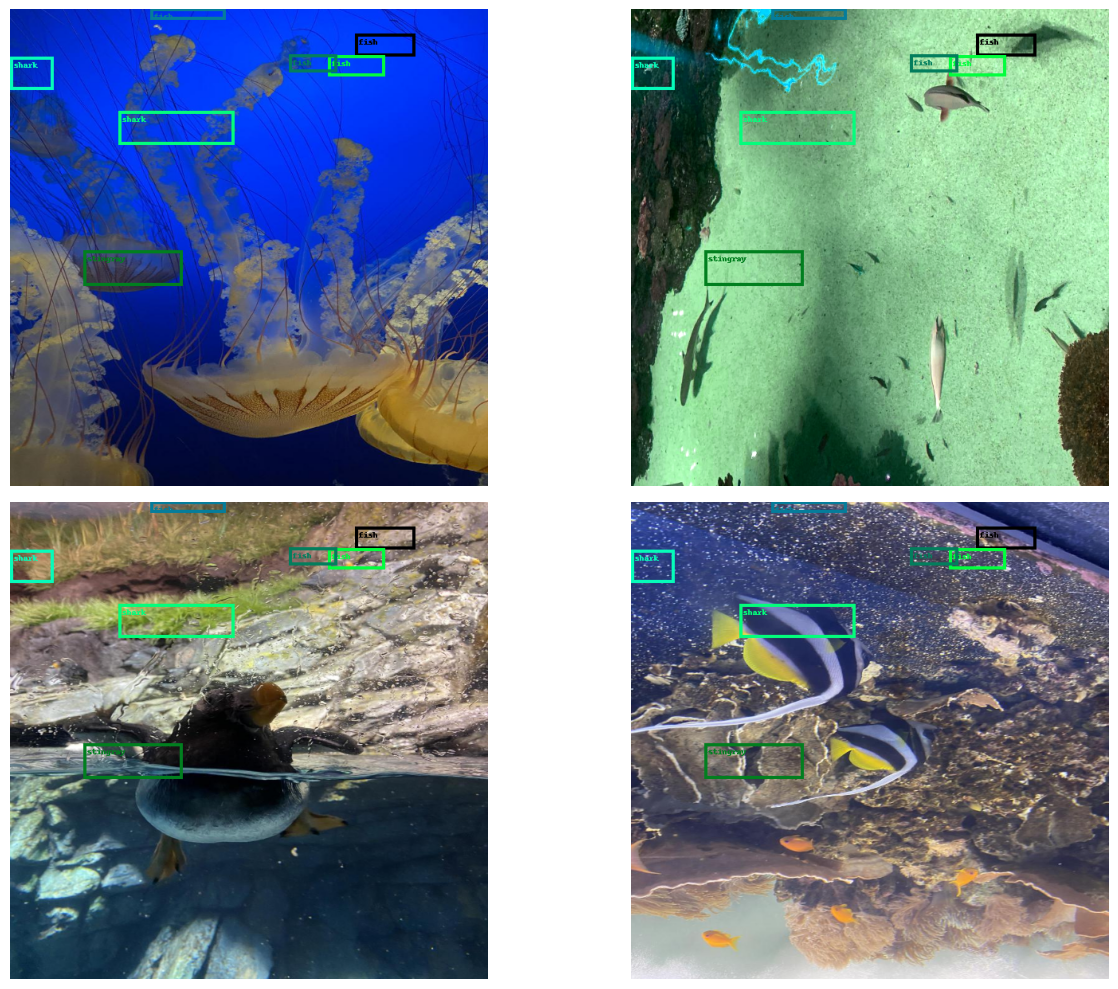

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loop through the subplots and plot the images with bounding boxes
for i, ax in enumerate(axes.flat):
    # Get the sample from the dataset
    sample = train_dataset[i]  # Assuming train_dataset contains the images and their corresponding annotations
    
    # Convert the image tensor to a numpy array
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
    
    # Perform prediction (replace this with your actual prediction code)
    # Assuming pred contains the predicted bounding boxes, labels, and scores
    pred_boxes = pred['boxes'][pred['scores'] > 0.8]
    pred_labels = [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()]
    
    # Draw bounding boxes on the image
    img_with_boxes = draw_bounding_boxes(img_int, pred_boxes, pred_labels, width=4).permute(1, 2, 0)
    
    # Plot the image with bounding boxes in the current subplot
    ax.imshow(img_with_boxes)
    ax.axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust the layout for better spacing between subplots
plt.show()  # Show the plot

In [28]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Mettez votre modèle en mode évaluation
model.eval()

# Liste pour stocker les prédictions et les vraies étiquettes
all_predictions = []
all_targets = []

# Boucle sur l'ensemble de test pour obtenir les prédictions et les étiquettes
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, target = test_dataset[i]
        prediction = model([img.to(device)])

        # Vérifiez si des prédictions ont été faites
        if 'labels' in prediction[0] and len(prediction[0]['labels']) > 0:
            # Convertir les boîtes prédites en classes
            pred_labels = [classes[i] for i in prediction[0]['labels'].tolist()]

            all_predictions.extend(pred_labels)
            all_targets.extend([classes[i] for i in target['labels'].tolist()])

# Assurez-vous que les listes ont la même longueur
if len(all_targets) != len(all_predictions):
    print("Nombre d'échantillons incorrects. Correction en cours...")
    min_length = min(len(all_targets), len(all_predictions))
    all_targets = all_targets[:min_length]
    all_predictions = all_predictions[:min_length]

# Calculer la précision et le rappel
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')

# Calculer la matrice de confusion
confusion = confusion_matrix(all_targets, all_predictions, labels=classes)

# Afficher les résultats
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Matrice de Confusion :")
print(confusion)

Nombre d'échantillons incorrects. Correction en cours...
Précision : 0.19
Rappel : 0.17
Matrice de Confusion :
[[  0   0   0   0   0   0   0   0]
 [  0 181   6  28  17  10   3   4]
 [  0 100  23  10   1   9   5   6]
 [  0  52   4  18   2   4   0   2]
 [  0  23   9   1   0   1   1   0]
 [  0  16   6   7   3   1   0   3]
 [  0   9   0   0   0   1   1   0]
 [  0   9   0   5   0   1   0   0]]


In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import average_precision_score

# Convertir les étiquettes en format de liste de listes
mlb = MultiLabelBinarizer(classes=classes)
binarized_targets = mlb.fit_transform([[label] for label in all_targets])
binarized_predictions = mlb.transform([[label] for label in all_predictions])

# Calculer la précision moyenne
average_precision = average_precision_score(binarized_targets, binarized_predictions)

# Afficher les résultats
print("mAP : {:.2f}".format(average_precision))

mAP : 0.14


In [30]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


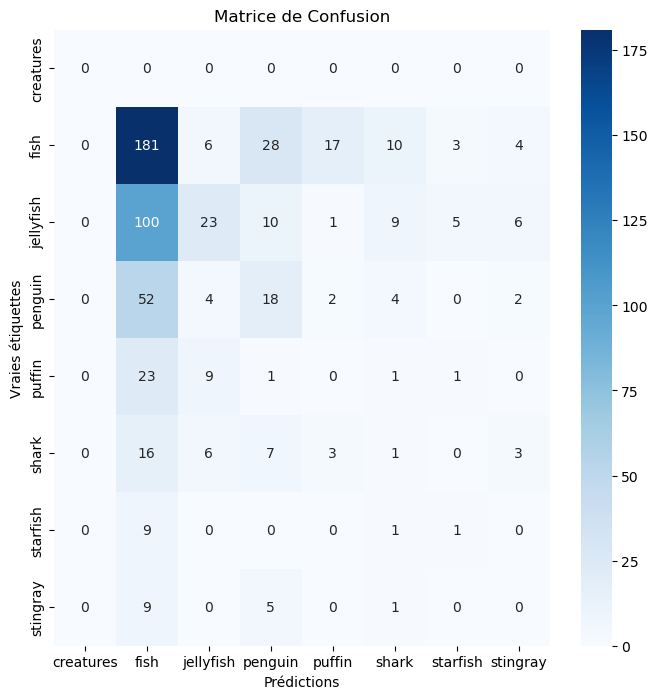

              precision    recall  f1-score   support

   creatures       0.00      0.00      0.00         0
        fish       0.46      0.73      0.57       249
   jellyfish       0.48      0.15      0.23       154
     penguin       0.26      0.22      0.24        82
      puffin       0.00      0.00      0.00        35
       shark       0.04      0.03      0.03        36
    starfish       0.10      0.09      0.10        11
    stingray       0.00      0.00      0.00        15

   micro avg       0.38      0.38      0.38       582
   macro avg       0.17      0.15      0.14       582
weighted avg       0.37      0.38      0.34       582



In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Importez seaborn ici


# ...

# Calculer la matrice de confusion
confusion = confusion_matrix(all_targets, all_predictions, labels=classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(len(classes), len(classes)))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (precision, recall, f1-score, support) pour chaque classe
print(classification_report(all_targets, all_predictions, labels=classes))
